# Нейронная сеть классификации рукописного текста датасета MNIST

### 1. Импорт библиотек и подготовка датасета (загрузка и нормализация)

In [217]:
# импорт библиотек
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [218]:
# Функция для нормализации датасета
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [219]:
# загрузка датасета
# тренировочная выборка
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
# тестовая выборка
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True)

In [220]:
# размер тензора с выборкой изображений и размер тензора с выборкой меток
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


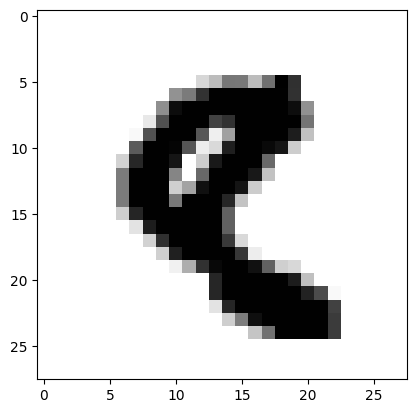

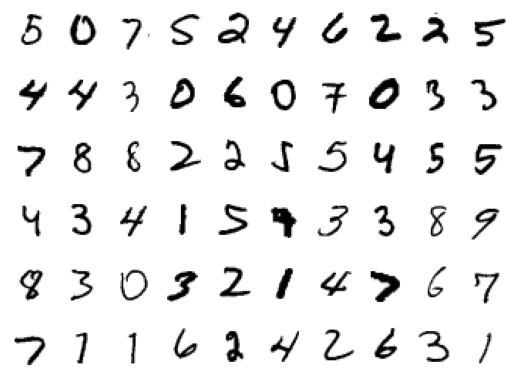

In [221]:
# Покажем часть выборки
# сначала одно изоборажение
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
# потом несколько
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images+1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### 2. Настройка параметров нейронной сети

![Картинка с сетью](./LNN_MNIST.png)

In [222]:
# количество входов
input_size = 28*28
# скрытые слои - один из 128 нейронов, другой из 64 нейронов
hidden_sizes = [562, 281, 140, 70]
# количество выходов
output_size = 10
# Создаем модель сети из 4 слоев с разными функциями активации
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=562, bias=True)
  (1): ReLU()
  (2): Linear(in_features=562, out_features=281, bias=True)
  (3): ReLU()
  (4): Linear(in_features=281, out_features=140, bias=True)
  (5): ReLU()
  (6): Linear(in_features=140, out_features=70, bias=True)
  (7): ReLU()
  (8): Linear(in_features=70, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)


### 3. Обучение сети

In [223]:
# функция определения потерь
criterion = nn.NLLLoss()
# обучающая выборка
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
# прогоняем выборку через сеть
logps = model(images)
# определяем потери
loss = criterion(logps, labels)

In [224]:
# нормализация весов в сети
print('потери до обратного распространения ошибки: \n', model[0].weight.grad)
loss.backward()
print('потери после обратного распространения ошибки: \n', model[0].weight.grad)

потери до обратного распространения ошибки: 
 None
потери после обратного распространения ошибки: 
 tensor([[-6.4466e-05, -6.4466e-05, -6.4466e-05,  ..., -6.4466e-05,
         -6.4466e-05, -6.4466e-05],
        [-4.3482e-04, -4.3482e-04, -4.3482e-04,  ..., -4.3482e-04,
         -4.3482e-04, -4.3482e-04],
        [-1.1138e-05, -1.1138e-05, -1.1138e-05,  ..., -1.1138e-05,
         -1.1138e-05, -1.1138e-05],
        ...,
        [ 2.1176e-05,  2.1176e-05,  2.1176e-05,  ...,  2.1176e-05,
          2.1176e-05,  2.1176e-05],
        [-1.2290e-05, -1.2290e-05, -1.2290e-05,  ..., -1.2290e-05,
         -1.2290e-05, -1.2290e-05],
        [ 3.6011e-06,  3.6011e-06,  3.6011e-06,  ...,  3.6011e-06,
          3.6011e-06,  3.6011e-06]])


In [225]:
# выбор оптимизатора - стохастический градиентный спуск
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# метка начала времени обучения нейронной сети
time0 = time()
# количество эпох обучения нейронной сети
epochs = 16
# основной цикл обучения нейронной сети
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # преобразуем изображение в вектор одного измерения длинной 28*28
        images = images.view(images.shape[0], -1)
        # обнулили градиенты в оптимизаторе
        optimizer.zero_grad()
        # прогнали выборку через сеть
        output = model(images)
        # посчитали потери
        loss = criterion(output, labels)
        # прогнали ошибку в обратном направлении
        loss.backward()
        # оптимизировали веса сети
        optimizer.step()
        # суммарные потери в этой эпохе
        running_loss += loss.item()
    else:
        # вывод статистики
        print(f"Эпоха {e+1} - Потери: {running_loss/len(trainloader):0.3}")
        print(f"Время тренировки {(time()-time0)/60:0.3} минут\n")

Эпоха 1 - Потери: 1.77
Время тренировки 0.213 минут

Эпоха 2 - Потери: 0.464
Время тренировки 0.434 минут

Эпоха 3 - Потери: 0.323
Время тренировки 0.65 минут

Эпоха 4 - Потери: 0.248
Время тренировки 0.889 минут

Эпоха 5 - Потери: 0.191
Время тренировки 1.11 минут

Эпоха 6 - Потери: 0.156
Время тренировки 1.33 минут

Эпоха 7 - Потери: 0.13
Время тренировки 1.54 минут

Эпоха 8 - Потери: 0.111
Время тренировки 1.74 минут

Эпоха 9 - Потери: 0.0962
Время тренировки 1.95 минут

Эпоха 10 - Потери: 0.0862
Время тренировки 2.16 минут

Эпоха 11 - Потери: 0.0763
Время тренировки 2.37 минут

Эпоха 12 - Потери: 0.0676
Время тренировки 2.6 минут

Эпоха 13 - Потери: 0.0601
Время тренировки 2.8 минут

Эпоха 14 - Потери: 0.0564
Время тренировки 3.02 минут

Эпоха 15 - Потери: 0.0498
Время тренировки 3.24 минут

Эпоха 16 - Потери: 0.0445
Время тренировки 3.44 минут



### 4. Тестирование нейронной сети

На картинке циферка  7


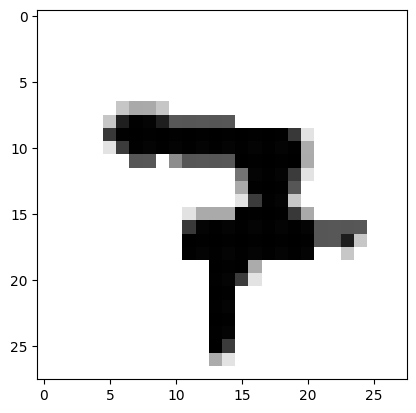

In [226]:
# сначала одно изоборажение
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

print("На картинке циферка ", probab.index(max(probab)))

In [227]:
# а теперь по всей тестовой выборке для определения точности нейросетевого классификатора
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print(f"Прогнали через сеть {all_count} изображений")
print(f"Точность нейросетевого классификатора = {correct_count/all_count}")

Прогнали через сеть 10000 изображений
Точность нейросетевого классификатора = 0.9738
